In [88]:
from scipy.stats import beta
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import StandardScaler
from bokeh.palettes import Category20_20
import arviz as az

*Scipy 的定义*

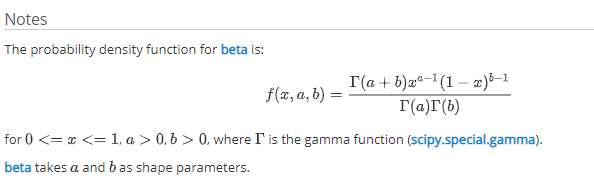

In [28]:
def plot_beta_scipy(a, b):
    x = np.linspace(0,1,100)
    pdf = [beta(a = a, b = b).pdf(xx) for xx in x]
    plt.plot(x,pdf, linewidth = 4, label = f'a = {a}\nb = {b}')
    plt.grid(linestyle = '--')
    plt.legend(loc = 'upper left')

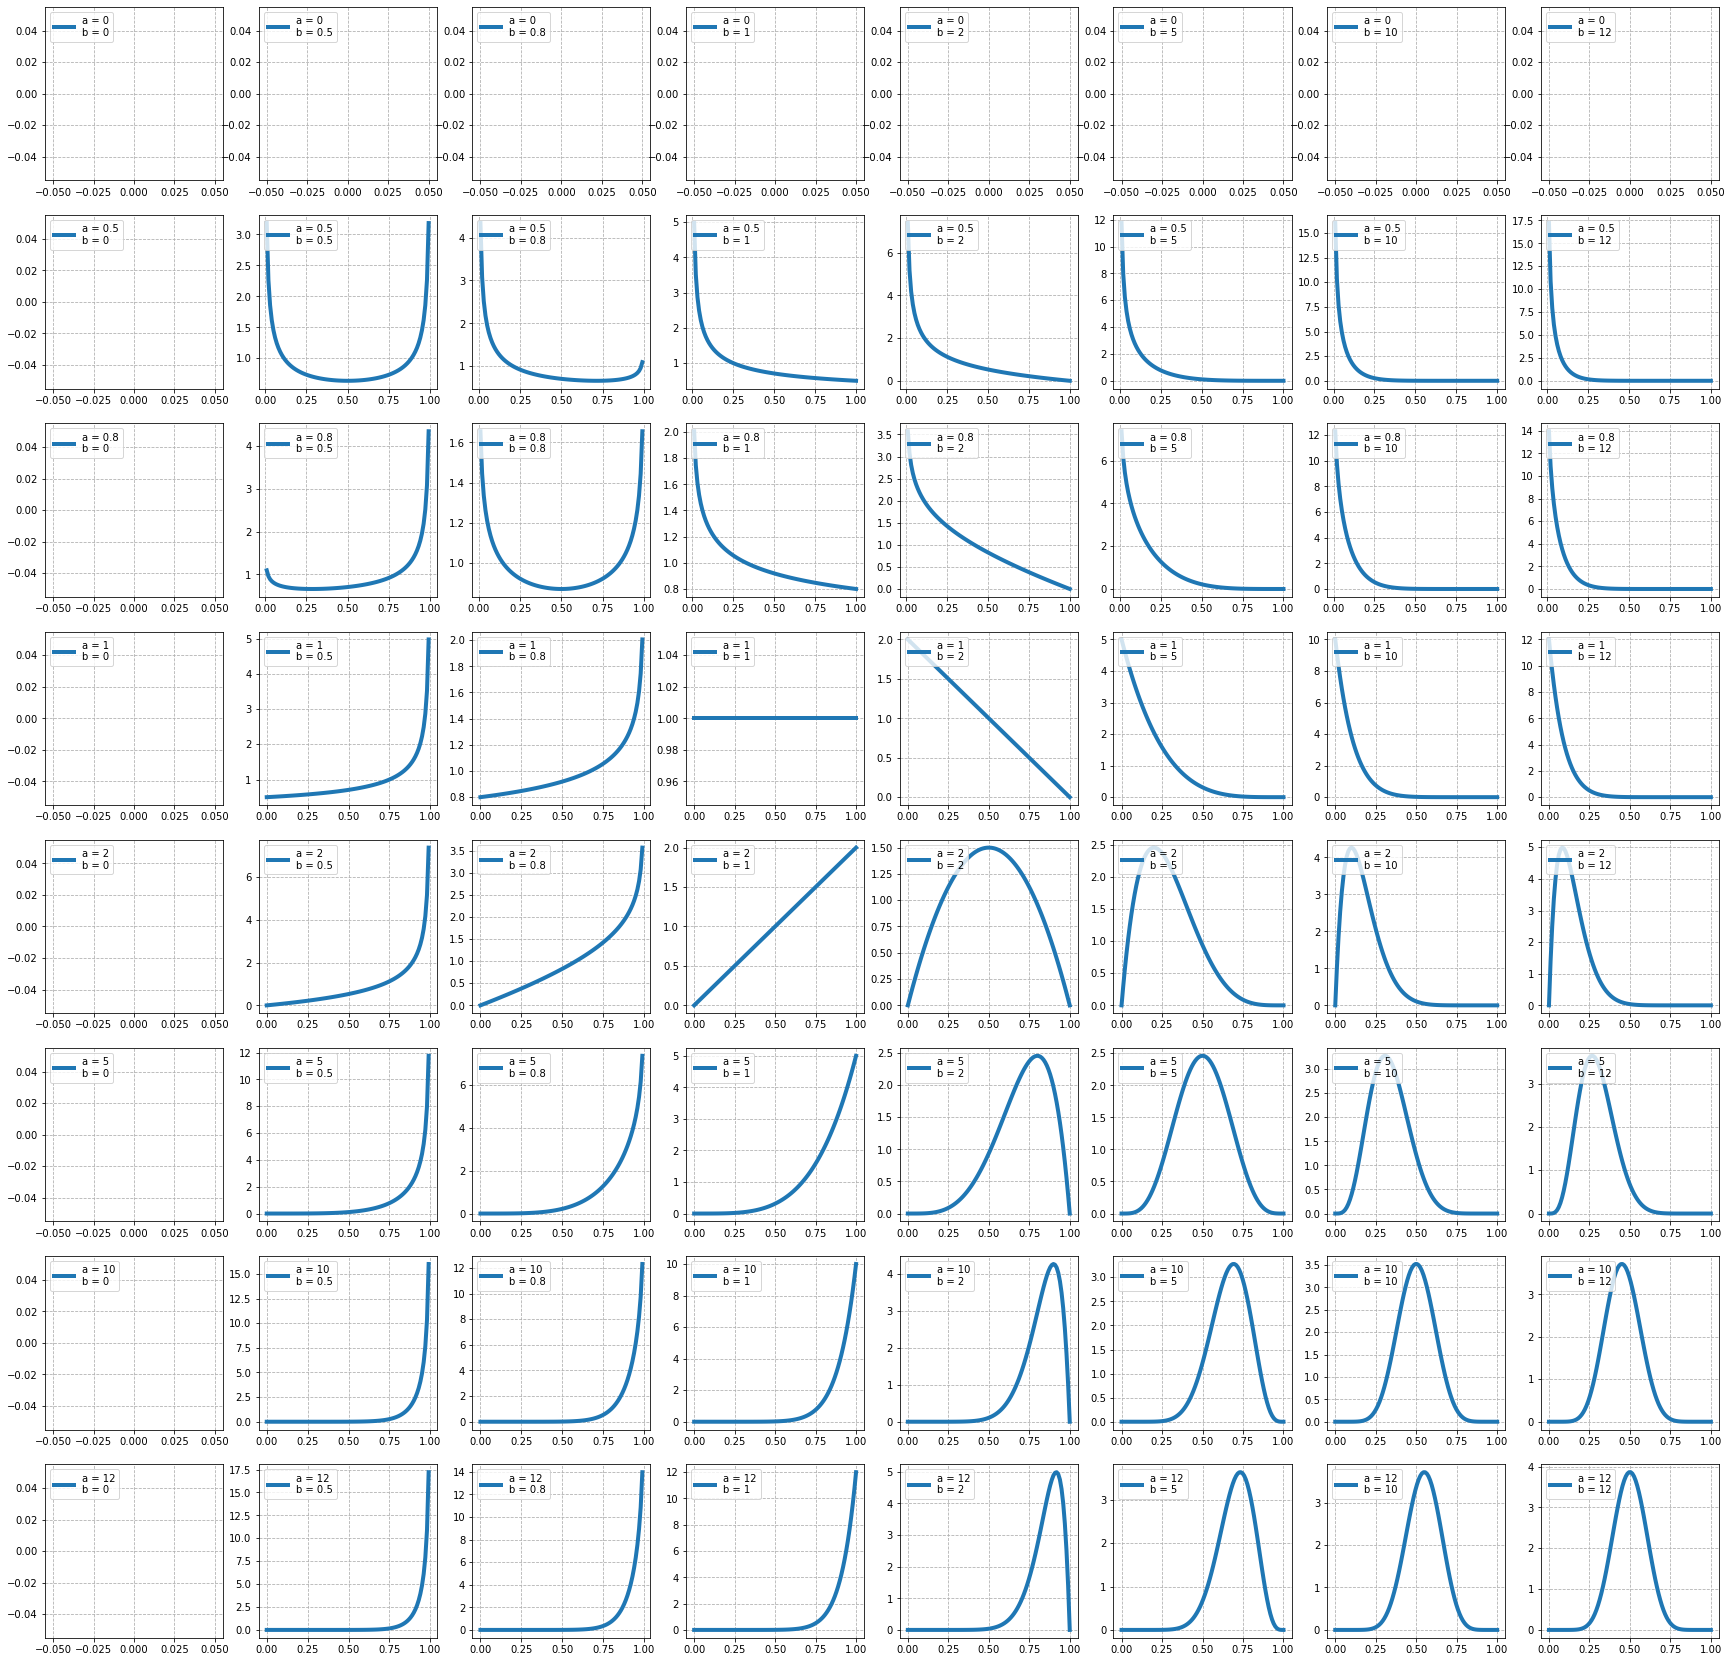

In [26]:
figsize(30,30)
cnt = 0
for a in [0,0.5,0.8,1,2,5,10,12]:
    for b in [0,0.5,0.8,1,2,5,10,12]:
        plt.subplot(8,8,cnt+1)
        plot_beta_scipy(a,b)
        cnt += 1

# 你发现了什么
1. a = 0 | b = 0的时候，beta是没有定义的
2. a = b的时候， beta是对称的
3. a > b的时候，右边的概率比较大（靠近1），右边大的时候，类似反指数的形状
4. a < b的时候，左边的概率比较大（靠近0），左边大的时候，类似正态分布形状(b>1)
5. a = 1, b = 1的时候，是uniform distribution
6. a = b < 1的时候， 诡异的宽抛物线形状
7. a,b其中有一个数为1， 且两个数只差的绝对值为1的时候，为直线，可能增函数，可能减函数
8. 鉴于这个东西再0，1之间，比较适合做某个概率的prior      


**你给个先验，也确定不了beta的形状，混乱一摊**

**用了loc一下，感觉非常诡异**

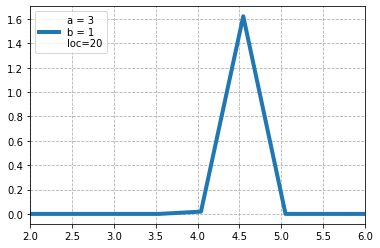

In [40]:
figsize(6,4)
x = np.linspace(0,50,100)
pdf = [beta(a = 3, b = 2, loc = 4).pdf(xx) for xx in x]
plt.plot(x,pdf, linewidth = 4, label = f'a = {3}\nb = {1}\nloc={20}')
plt.grid(linestyle = '--')
plt.xlim(2,6)
plt.legend(loc = 'upper left')

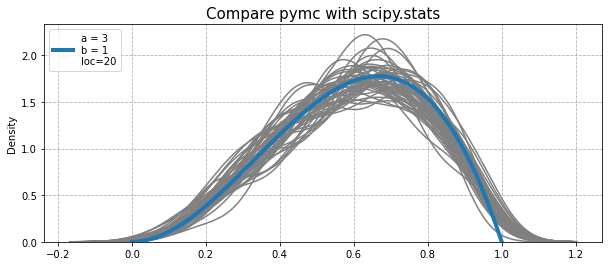

In [57]:
figsize(10,4)
x = np.linspace(0,1,100)

with pm.Model() as model:
    be = pm.Beta('be',3, 2)
    
for i in range(50):
    sns.kdeplot(be.random(size = 200), color = 'gray', alpha = 0.01)
    
pdf = [beta(a = 3, b = 2).pdf(xx) for xx in x]
plt.plot(x,pdf, linewidth = 4, label = f'a = {3}\nb = {1}\nloc={20}')
plt.grid(linestyle = '--')
plt.legend(loc = 'upper left')

plt.title('Compare pymc with scipy.stats', fontsize = 15)
plt.show()

# 使用Beta当作prior

In [64]:
from scipy.stats import bernoulli

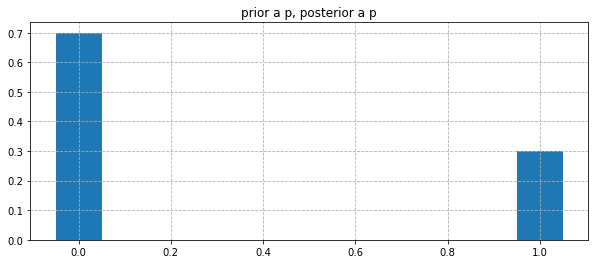

In [77]:
p = beta(3,2).rvs(100)

xx = np.linspace(0,1,100)
pmf = [bernoulli(p = 0.3).pmf(x) 
     for x in xx]

plt.bar(xx, pmf, width = 0.1)
plt.grid(linestyle = '--')
plt.title("prior a p, posterior a p")
plt.show()

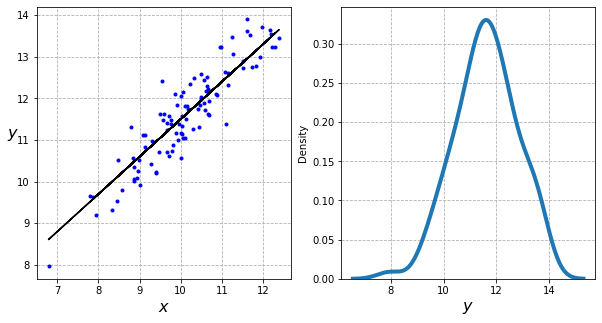

In [82]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.grid(linestyle = '--')
plt.plot(x, y_real, 'k')

plt.subplot(1,2,2)
sns.kdeplot(y, linewidth = 4)
plt.xlabel('$y$', fontsize=16)
plt.grid(linestyle = '--')
plt.show()

说我们现在要线性回归了， 截距是2.5， 斜率是0.9，我们看能不能找出来

对于截距alpha来说，我们设置一个很大的标准差，多大呢，有的直线的截距是10000，你总不能设置一个10000的normal吧。              
对于斜率来说，变化范围也非常的广，你总不能设置一个10000的斜率吧，这就非常蛋疼了       

#### 我肉眼一看
1. 截距肯定小于10啊， 我把标准差设置成30，怎么也可以了把
2. 横坐标和纵坐标的数量级差别也不大，我就设置成0附近，20的标准差， 也总是可以的吧
3. 我看了一下yhat - y的感觉，差不多也就个位数，我设置一个halfcauchy

In [97]:
with pm.Model() as model:
    alpha = pm.Normal('alpha',mu = 0,sigma = 30)
    beta = pm.Normal('beta',mu = 0,sigma = 20)
    
    epsilon = pm.HalfCauchy('epsilon', beta = 10)
    
    mu = pm.Deterministic('mu',alpha  + beta * x)
    y_pred = pm.Normal('y',mu = mu, sigma = epsilon, observed = y)
    step = pm.Metropolis()
    start = pm.find_MAP()
    
    trace = pm.sample(40000, step = step, start = start, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 71 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


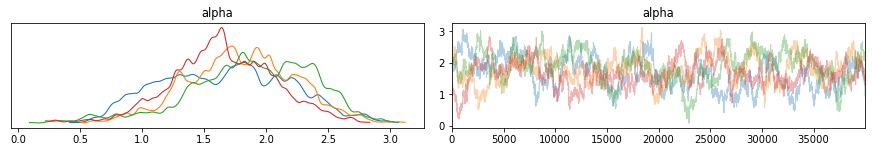

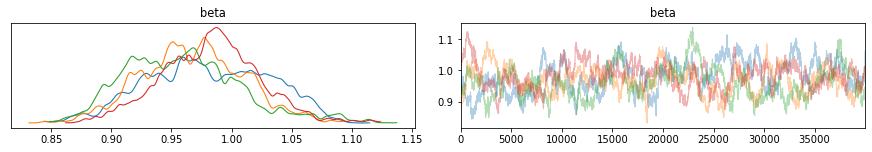

In [98]:
az.plot_trace(trace.posterior['alpha'])
plt.show()
az.plot_trace(trace.posterior['beta'])
plt.show()

可以看到，这个线性回归做的还是宛如智障的               


### 回归问题，做好了行，做不好宛如智障

In [103]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.751,0.475,0.861,2.614,0.065,0.046,54.0,54.0,56.0,243.0,1.08
beta,0.973,0.047,0.891,1.064,0.006,0.005,54.0,53.0,56.0,250.0,1.08
epsilon,0.474,0.034,0.413,0.542,0.000,0.000,15523.0,15463.0,15718.0,19810.0,1.00
mu[0],11.660,0.047,11.570,11.749,0.000,0.000,34131.0,34128.0,34046.0,34986.0,1.00
mu[1],9.986,0.092,9.811,10.153,0.011,0.008,70.0,70.0,71.0,360.0,1.06
...,...,...,...,...,...,...,...,...,...,...,...
mu[95],11.064,0.054,10.959,11.165,0.004,0.003,231.0,231.0,231.0,1643.0,1.02
mu[96],13.123,0.086,12.961,13.283,0.009,0.007,87.0,87.0,88.0,510.0,1.05
mu[97],9.412,0.116,9.188,9.622,0.015,0.010,62.0,62.0,63.0,318.0,1.07
mu[98],12.157,0.054,12.056,12.260,0.002,0.002,517.0,517.0,518.0,2992.0,1.01


## In fact, it is really fine to use the regressed line

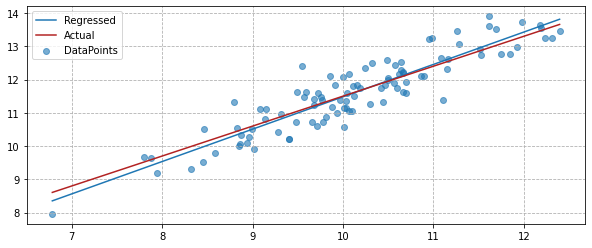

In [113]:
xx = np.linspace(x.min(), x.max(), 100)
yy = xx * 0.973 + 1.751
yy_true = xx * 0.9 + 2.5
plt.plot(xx,yy, label = 'Regressed')
plt.plot(xx, yy_true, color = 'firebrick', label = 'Actual')
plt.scatter(x,y, alpha = 0.6, label = 'DataPoints')
plt.grid(linestyle = '--')
plt.legend(loc = 'upper left')
plt.
plt.show()

# 我把先验做成宛如智障，试一试

In [114]:
with pm.Model() as model:
    alpha = pm.Normal('alpha',mu = 1000,sigma = 30)
    beta = pm.Normal('beta',mu = 1000,sigma = 20)
    
    epsilon = pm.HalfCauchy('epsilon', beta = 10)
    
    mu = pm.Deterministic('mu',alpha  + beta * x)
    y_pred = pm.Normal('y',mu = mu, sigma = epsilon, observed = y)
    step = pm.Metropolis()
    start = pm.find_MAP()
    
    trace = pm.sample(40000, step = step, start = start, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 72 seconds.
The number of effective samples is smaller than 25% for some parameters.


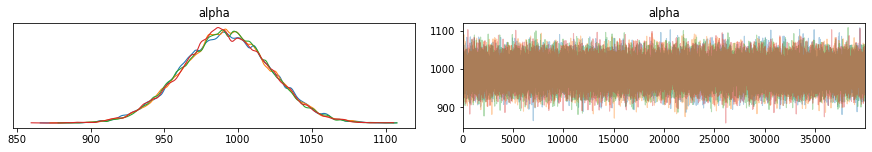

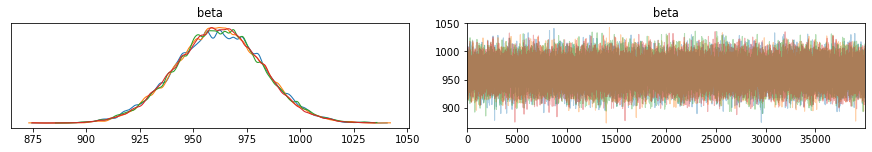

In [115]:
az.plot_trace(trace.posterior['alpha'])
plt.show()
az.plot_trace(trace.posterior['beta'])
plt.show()

In [116]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,991.558,30.094,935.181,1048.231,0.163,0.115,34273.0,34273.0,34259.0,39108.0,1.0
beta,961.860,20.411,923.913,1000.778,0.117,0.083,30481.0,30481.0,30484.0,39414.0,1.0
epsilon,10806.165,801.018,9296.949,12291.584,5.592,3.955,20517.0,20513.0,20578.0,22613.0,1.0
mu[0],10789.431,210.154,10395.507,11185.718,1.203,0.850,30538.0,30538.0,30539.0,40573.0,1.0
mu[1],9134.911,175.478,8805.466,9465.378,1.004,0.710,30567.0,30567.0,30567.0,40996.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu[95],10200.087,197.785,9828.368,10572.235,1.132,0.800,30547.0,30547.0,30548.0,40680.0,1.0
mu[96],12236.480,240.585,11784.462,12688.791,1.377,0.974,30523.0,30523.0,30525.0,40365.0,1.0
mu[97],8567.110,163.621,8259.667,8874.874,0.936,0.662,30582.0,30582.0,30581.0,41087.0,1.0
mu[98],11280.922,220.481,10866.464,11695.280,1.262,0.892,30532.0,30532.0,30534.0,40554.0,1.0


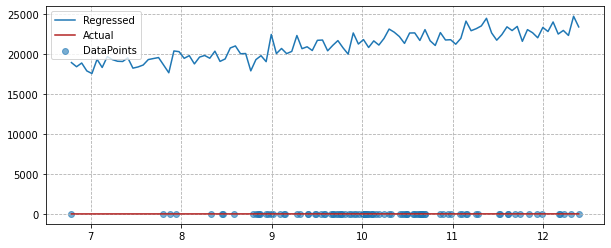

In [119]:
xx = np.linspace(x.min(), x.max(), 100)
yy = xx * 961+ 991 + np.random.normal(10806,801, size = len(xx))
yy_true = xx * 0.9 + 2.5
plt.plot(xx,yy, label = 'Regressed')
plt.plot(xx, yy_true, color = 'firebrick', label = 'Actual')
plt.scatter(x,y, alpha = 0.6, label = 'DataPoints')
plt.grid(linestyle = '--')
plt.legend(loc = 'upper left')
plt.show()

然后就真的做成了一堆屎， **贝叶斯的线性回归不是普遍使用的线性回归，只是多了一些不确定性的蹩脚的， 需要调整的线性回归**

# 有没有对于线性回归自动设置先验的方法

In [133]:
slope_scale = (y/x).max() - (y/x).min()
slope, interc = np.polyfit(x,y,deg = 1)
custom_error = 3 * y.std()

In [134]:
with pm.Model() as model:
    alpha = pm.Normal('alpha',mu = interc,sigma = custom_error)
    beta = pm.Normal('beta',mu = slope,sigma = slope_scale)
    
    epsilon = pm.HalfCauchy('epsilon', beta = custom_error)
    
    mu = pm.Deterministic('mu',alpha  + beta * x)
    y_pred = pm.Normal('y',mu = mu, sigma = epsilon, observed = y)
    step = pm.Metropolis()
    start = pm.find_MAP()
    
    trace = pm.sample(40000, step = step, start = start, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 72 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


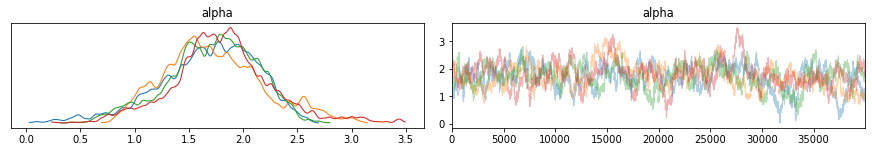

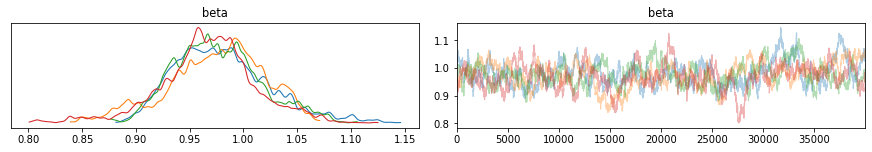

In [135]:
az.plot_trace(trace.posterior['alpha'])
plt.show()
az.plot_trace(trace.posterior['beta'])
plt.show()

In [136]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.732,0.444,0.857,2.532,0.041,0.029,118.0,118.0,119.0,158.0,1.02
beta,0.975,0.044,0.897,1.061,0.004,0.003,118.0,118.0,119.0,147.0,1.02
epsilon,0.473,0.034,0.412,0.540,0.000,0.000,15894.0,15894.0,15903.0,18548.0,1.00
mu[0],11.660,0.047,11.572,11.749,0.000,0.000,38940.0,38940.0,38868.0,38718.0,1.00
mu[1],9.983,0.086,9.814,10.141,0.007,0.005,156.0,156.0,157.0,317.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
mu[95],11.063,0.053,10.963,11.163,0.002,0.002,475.0,475.0,476.0,1952.0,1.01
mu[96],13.126,0.083,12.970,13.284,0.006,0.004,188.0,188.0,190.0,398.0,1.02
mu[97],9.408,0.109,9.199,9.611,0.009,0.007,137.0,137.0,138.0,240.0,1.02
mu[98],12.158,0.053,12.059,12.260,0.002,0.001,720.0,720.0,720.0,3038.0,1.00


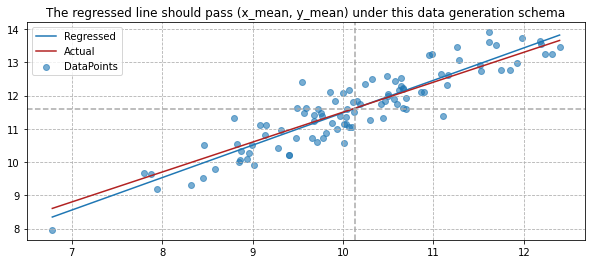

In [161]:
xx = np.linspace(x.min(), x.max(), 100)
yy = xx * 0.975 + 1.732
yy_true = xx * 0.9 + 2.5
plt.plot(xx,yy, label = 'Regressed')
plt.plot(xx, yy_true, color = 'firebrick', label = 'Actual')
plt.scatter(x,y, alpha = 0.6, label = 'DataPoints')
plt.axvline(x.mean(), linestyle = '--', color = 'darkgray')
plt.axhline(y.mean(), linestyle = '--', color = 'darkgray')
plt.grid(linestyle = '--')
plt.legend(loc = 'upper left')
plt.title('The regressed line should pass (x_mean, y_mean) under this data generation schema')
plt.show()

回归出来的线，就像钉在了x_mean, y_mean，然后转动，找到合适的值。 **其实这个地方，我还挺不理解的**

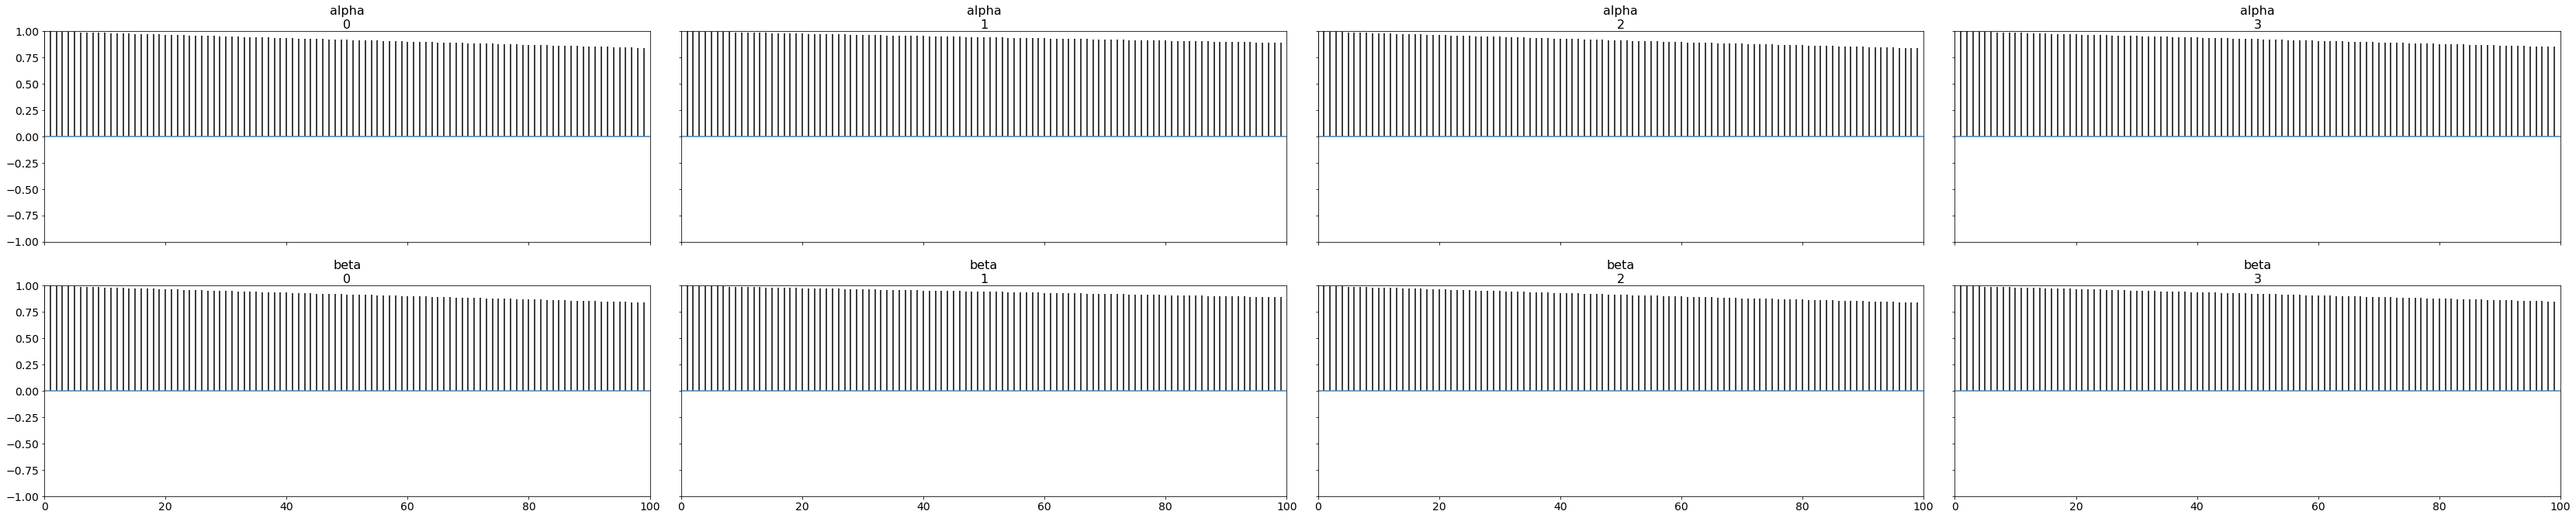

In [143]:
az.plot_autocorr(trace, var_names=['alpha','beta'])
plt.show()

显然我们再alpha和beta的拟合上， 出了一些问题。

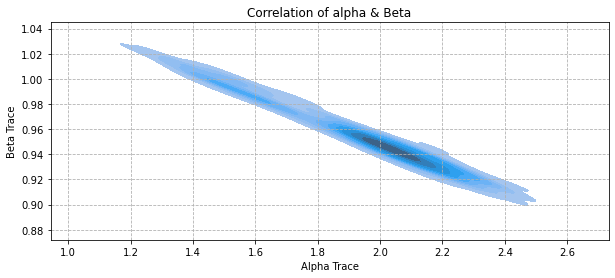

In [154]:
sns.kdeplot(x = trace.posterior['alpha'].values.reshape(-1)[-1000:], 
            y = trace.posterior['beta'].values.reshape(-1)[-1000:],shade = True)
plt.grid(linestyle = '--')
plt.title('Correlation of alpha & Beta')
plt.xlabel('Alpha Trace')
plt.ylabel('Beta Trace')
plt.show()

这个事情说明，你提出一个alpha的 proposal， 然后再这个proposal下，去找beta的proposal， 落在蓝色区域概率很小，大多数时候，Metropolis就给你reject掉了。所以你最后有效的sample比较少。              

In [191]:
scalerx = StandardScaler()
x_transformed = scalerx.fit_transform(np.array([x]).reshape(-1,1)).reshape(-1)

scalery = StandardScaler()
y_transformed = scalery.fit_transform(np.array([y]).reshape(-1,1)).reshape(-1)

slope_scale = (y_transformed/x_transformed).max() - (y_transformed/x_transformed).min()
slope, interc = np.polyfit(x_transformed,y_transformed,deg = 1)
custom_error = 3 * y_transformed.std()


with pm.Model() as model:
    alpha = pm.Normal('alpha',mu = interc,sigma = custom_error)
    beta = pm.Normal('beta',mu = slope,sigma = slope_scale)
    
    epsilon = pm.HalfCauchy('epsilon', beta = custom_error)
    
    mu = pm.Deterministic('mu',alpha  + beta * x_transformed)
    y_pred = pm.Normal('y',mu = mu, sigma = epsilon, observed = y_transformed)
    step = pm.Metropolis()
    start = pm.find_MAP()
    
    trace = pm.sample(40000, step = step, start = start, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 72 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016960498DF0>,
      dtype=object)

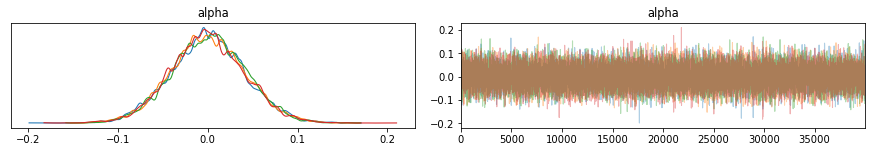

In [192]:
az.plot_trace(trace.posterior['alpha'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000169027DA850>,
      dtype=object)

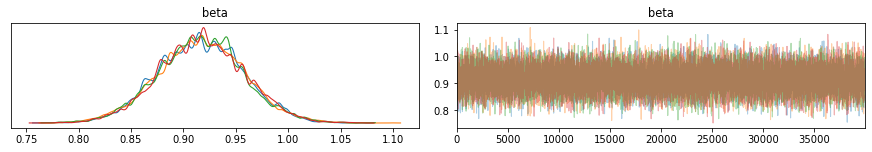

In [193]:
az.plot_trace(trace.posterior['beta'])

In [194]:
summary = az.summary(trace)

In [209]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.041,-0.078,0.078,0.000,0.0,22216.0,18177.0,22146.0,23561.0,1.0
beta,0.917,0.041,0.839,0.994,0.000,0.0,21369.0,21367.0,21331.0,23216.0,1.0
epsilon,0.409,0.030,0.354,0.466,0.000,0.0,19646.0,19646.0,19616.0,20889.0,1.0
mu[0],0.048,0.041,-0.029,0.127,0.000,0.0,22266.0,21297.0,22189.0,23956.0,1.0
mu[1],-1.399,0.075,-1.544,-1.259,0.001,0.0,21350.0,21350.0,21309.0,29117.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu[95],-0.467,0.047,-0.557,-0.381,0.000,0.0,21694.0,21694.0,21648.0,28314.0,1.0
mu[96],1.314,0.072,1.174,1.445,0.000,0.0,22039.0,22029.0,21981.0,29785.0,1.0
mu[97],-1.895,0.095,-2.071,-1.713,0.001,0.0,21288.0,21288.0,21250.0,27603.0,1.0
mu[98],0.478,0.046,0.392,0.567,0.000,0.0,22481.0,22481.0,22394.0,28438.0,1.0


In [195]:
interc = summary.loc['alpha','mean']
slope = summary.loc['beta','mean']

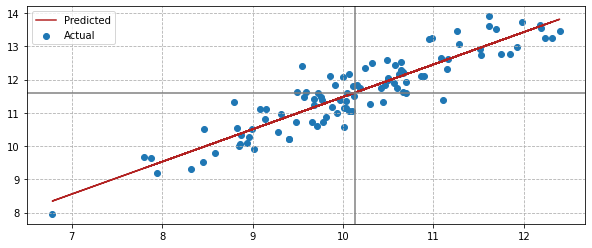

In [208]:
tran_x_test = scalerx.transform(x.reshape(-1,1)).reshape(-1)
pred_y = slope * tran_x_test + interc
pred_y = scalery.inverse_transform(pred_y.reshape(-1,1)).reshape(-1)

plt.plot(x,pred_y, color = 'firebrick',label = 'Predicted')
plt.scatter(x,y, label = 'Actual')
plt.grid(linestyle = '--')
plt.axvline(x.mean(), color = 'gray')
plt.axhline(y.mean(), color = 'gray')
plt.legend(loc = 'upper left')
plt.show()

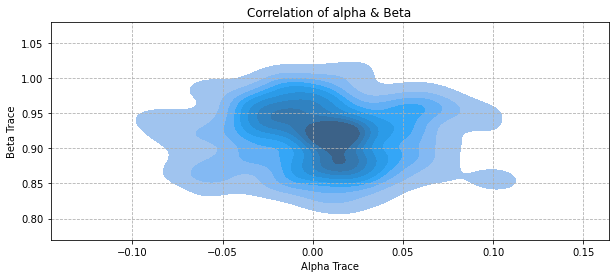

In [210]:
sns.kdeplot(x = trace.posterior['alpha'].values.reshape(-1)[-1000:], 
            y = trace.posterior['beta'].values.reshape(-1)[-1000:],shade = True)
plt.grid(linestyle = '--')
plt.title('Correlation of alpha & Beta')
plt.xlabel('Alpha Trace')
plt.ylabel('Beta Trace')
plt.show()

## At least, the sample space looks better

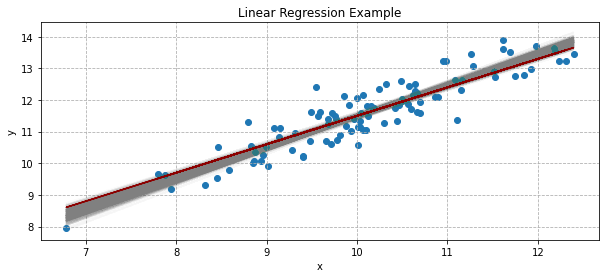

In [221]:
tran_x_test = scalerx.transform(x.reshape(-1,1)).reshape(-1)

for slope, interc in zip(trace.posterior['beta'].values.reshape(-1)[-1000:],
                        trace.posterior['alpha'].values.reshape(-1)[-1000:]):
    
    pred_y = slope * tran_x_test + interc
    pred_y = scalery.inverse_transform(pred_y.reshape(-1,1)).reshape(-1)
    plt.plot(x,pred_y, color = 'gray',alpha = 0.01)

plt.plot(x, 0.9*x + 2.5, color = 'darkred')
plt.scatter(x,y, label = 'Actual')
plt.grid(linestyle = '--')
plt.title('Linear Regression Example')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

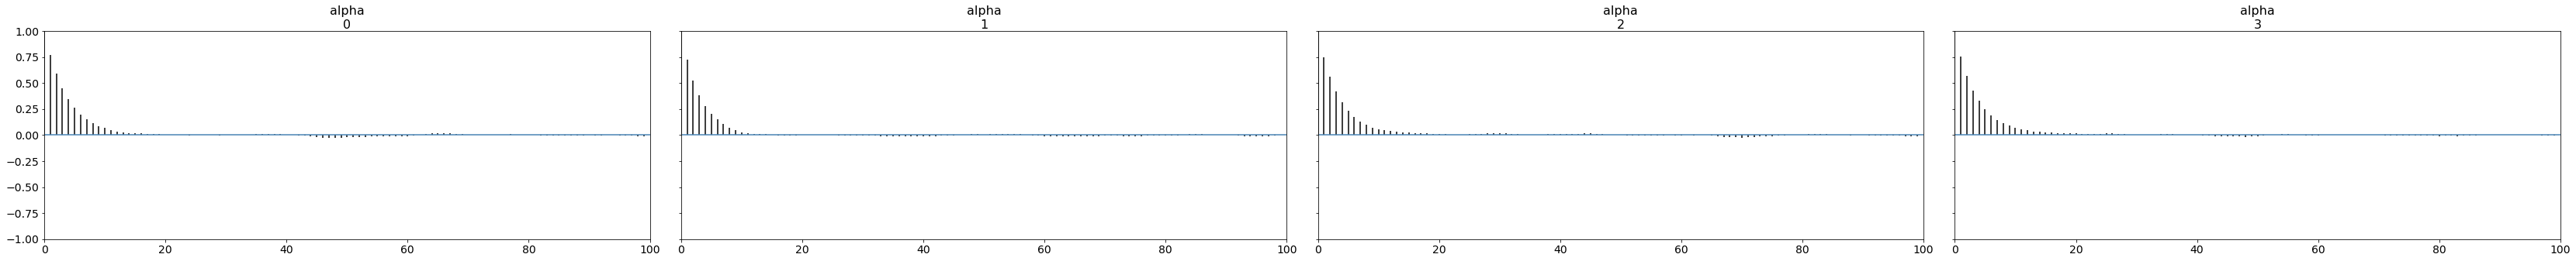

In [223]:
az.plot_autocorr(trace.posterior['alpha'])
plt.show()

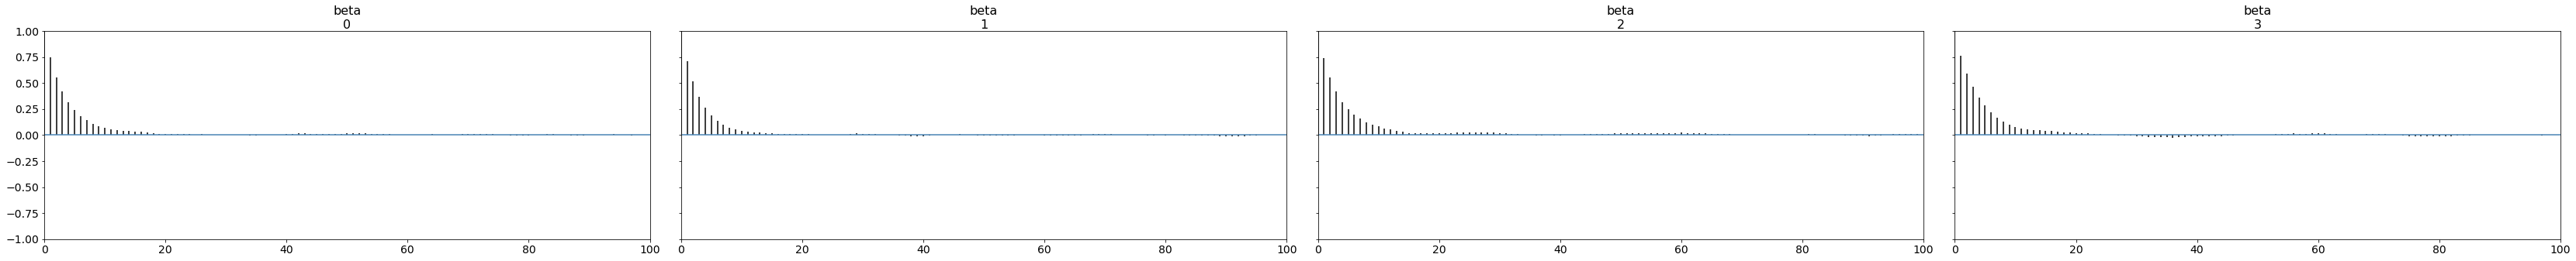

In [224]:
az.plot_autocorr(trace.posterior['beta'])
plt.show()

### Seems that we fit the line